## Problem
#### Given a dataset with ranges flagged as suspect for biofouling, determine a point in time to begin exclusion of data.
There may be events (features) in data that are flagged as suspect where biofouling is not the cause. We will attempt to identify these as flagged data followed by periods of good data, because we do not expect good data from a sensor once it becomes fouled. We attempt here to look for these features, and only exclude flagged data once it is no longer followed by good data.

The metric for programatically identifying data to flag as suspect is not considered here.

In [1]:
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
#Load the sample datasets with xarray...
data1 = xr.load_dataset('data/example_data1.nc')
data2 = xr.load_dataset('data/example_data2.nc')

#### Original dataset 'data1' with human-flagged range
Here's what the first dataset looks like, with human-flagged data in red...

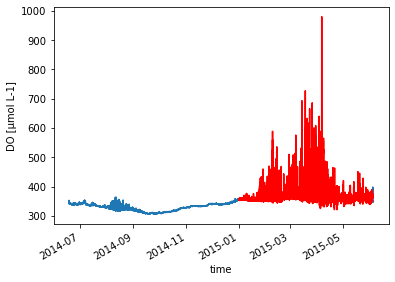

In [3]:
data1_qc_manual = data1.groupby('rollup_annotations_qc_results')
data1_qc_manual[0].estimated_oxygen_concentration.plot()
data1_qc_manual[3].estimated_oxygen_concentration.plot(color='r')

#### Use a stand-in metric to flag data, so we have something to work with
Let's use the daily standard deviation. Here's what that looks like...

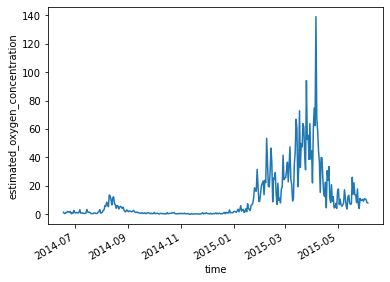

In [4]:
# Resample data1 by day and get standard deviation...
data1_daily_std = data1.estimated_oxygen_concentration.resample(time='D').std()
data1_daily_std.plot()

Now we'll arbitrarily flag all days with standard deviation greater than 5...

In [5]:
# Flag data1 based on daily standard deviation...
data1_qcflag_5 = xr.where(data1_daily_std > 5, 1, 0)

#### Find the exclusion start date
Write a function to choose the date to begin excluding data, skipping over flagged data if it's followed by good data. We can specify this interval...

Input is an xarray (or similar) with flagged data as zeros, and time.

In [6]:
def get_qcflag_start_date(qcflags, max_zero=7):
    """Returns a date to begin data exclusion, ignoring flagged data
    if followed by max_zero unflagged intervals.
    """
    flag_start = None
    flag_count = 0
    zero_count = 0
    for flag in qcflags:
        if abs(flag) > 0:
            zero_count = 0
            if not flag_start:
                flag_start = flag.time
            flag_count +=1
        elif flag == 0:
            zero_count +=1
        if zero_count == max_zero:
            flag_start = None
    return flag_start

Let's try it on the example flagged dataset. We'll use the default of 7 for the zero threshold, since that represents one week. We want it to skip over the feature in the data in August...

In [7]:
get_qcflag_start_date(data1_qcflag_5)

<xarray.DataArray 'time' ()>
array('2015-01-17T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2015-01-17

Great, it says we should start excluding our data on 17 Jan 2015.

For further proof of concept, let's make the zero interval very large. We should see it flag the data from August this time...

In [8]:
# set the zero interval to 300...
get_qcflag_start_date(data1_qcflag_5, 300)

<xarray.DataArray 'time' ()>
array('2014-08-05T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2014-08-05

Nice, now let's see if making it smaller will make it flag the data later...

In [9]:
# set the zero interval to 2...
get_qcflag_start_date(data1_qcflag_5, 2)

<xarray.DataArray 'time' ()>
array('2015-04-29T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2015-04-29

Good. Now let's go back to the default interval and create a mask for some plots...

#### Create some plots

Since my plots don't look that nice, we'll use the plotting code provided by Thiago Caminha. Thanks, Thiago!

First, let's remind ourselves what the original human-flagged dataset looks like...

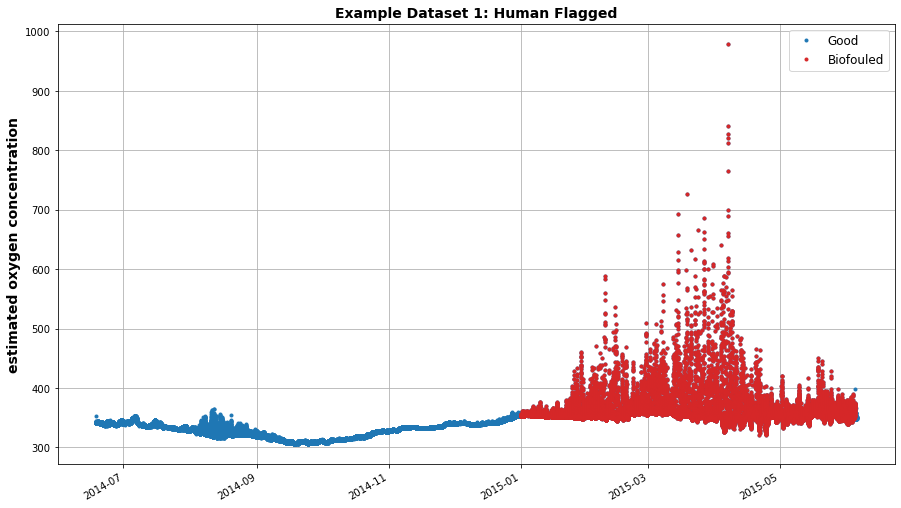

In [10]:
# Plot the dataset with the annotations
# Set the figure size and axes
fig, ax = plt.subplots(figsize=(15, 9))

# Plot the oxygen data
ax.plot(data1["time"], data1["estimated_oxygen_concentration"], marker=".", linestyle="", color="tab:blue", label="Good")

# Find and plot just the annotations using "pandas-like" boolean masking
mask = data1["rollup_annotations_qc_results"] == 3
ax.plot(data1["time"][mask], data1["estimated_oxygen_concentration"][mask], marker=".", linestyle="", color="tab:red", label="Biofouled")

# Add the lables, legends, grid, etc
ax.set_ylabel("estimated oxygen concentration", fontsize=14, weight="bold")
ax.grid()
ax.legend(fontsize=12)
ax.set_title("Example Dataset 1: Human Flagged", fontsize=14, weight="bold")

# Set the x-axis as a time axis
fig.autofmt_xdate()

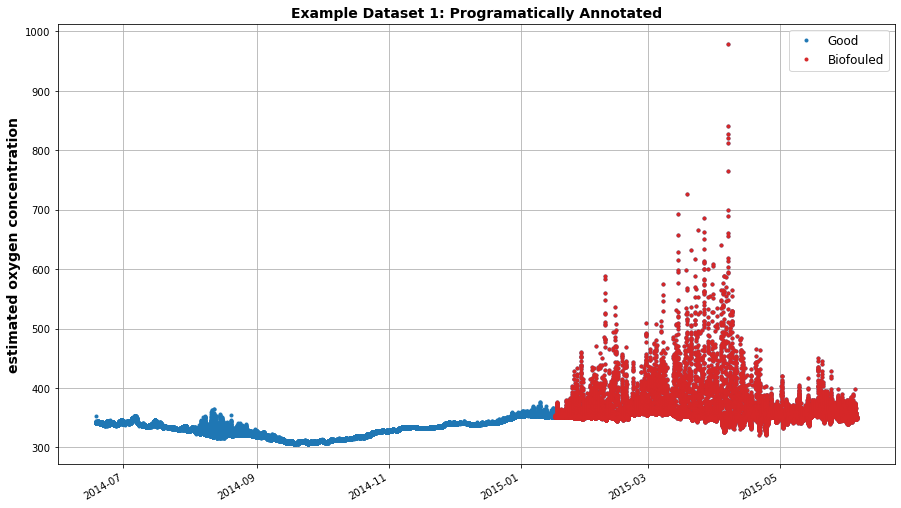

In [11]:
# Get our data exclusion start date and use that as a mask
exclusion_date = get_qcflag_start_date(data1_qcflag_5)
mask = data1["time"] >= exclusion_date


# Plot the dataset with the annotations
# Set the figure size and axes
fig, ax = plt.subplots(figsize=(15, 9))

# Plot the oxygen data
ax.plot(data1["time"], data1["estimated_oxygen_concentration"], marker=".", linestyle="", color="tab:blue", label="Good")

# Find and plot just the annotations using "pandas-like" boolean masking
ax.plot(data1["time"][mask], data1["estimated_oxygen_concentration"][mask], marker=".", linestyle="", color="tab:red", label="Biofouled")

# Add the lables, legends, grid, etc
ax.set_ylabel("estimated oxygen concentration", fontsize=14, weight="bold")
ax.grid()
ax.legend(fontsize=12)
ax.set_title("Example Dataset 1: Programatically Annotated", fontsize=14, weight="bold")

# Set the x-axis as a time axis
fig.autofmt_xdate()

#### Example dataset 2

Let's do all the same to the second dataset. Again, we'll use daily standard deviation greater than 5 as a stand-in metric for flagging data.

In [12]:
# Resample data1 by day and get standard deviation...
data2_daily_std = data2.estimated_oxygen_concentration.resample(time='D').std()
# Flag data1 based on daily standard deviation...
data2_qcflag_5 = xr.where(data2_daily_std > 5, 1, 0)

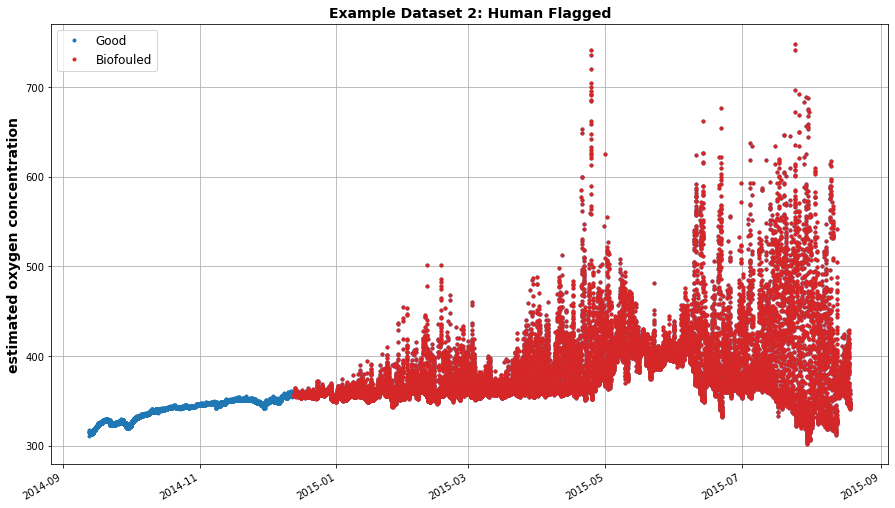

In [13]:
# Plot the dataset with the annotations
# Set the figure size and axes
fig, ax = plt.subplots(figsize=(15, 9))

# Plot the oxygen data
ax.plot(data2["time"], data2["estimated_oxygen_concentration"], marker=".", linestyle="", color="tab:blue", label="Good")

# Find and plot just the annotations using "pandas-like" boolean masking
mask = data2["rollup_annotations_qc_results"] == 3
ax.plot(data2["time"][mask], data2["estimated_oxygen_concentration"][mask], marker=".", linestyle="", color="tab:red", label="Biofouled")

# Add the lables, legends, grid, etc
ax.set_ylabel("estimated oxygen concentration", fontsize=14, weight="bold")
ax.grid()
ax.legend(fontsize=12)
ax.set_title("Example Dataset 2: Human Flagged", fontsize=14, weight="bold")

# Set the x-axis as a time axis
fig.autofmt_xdate()

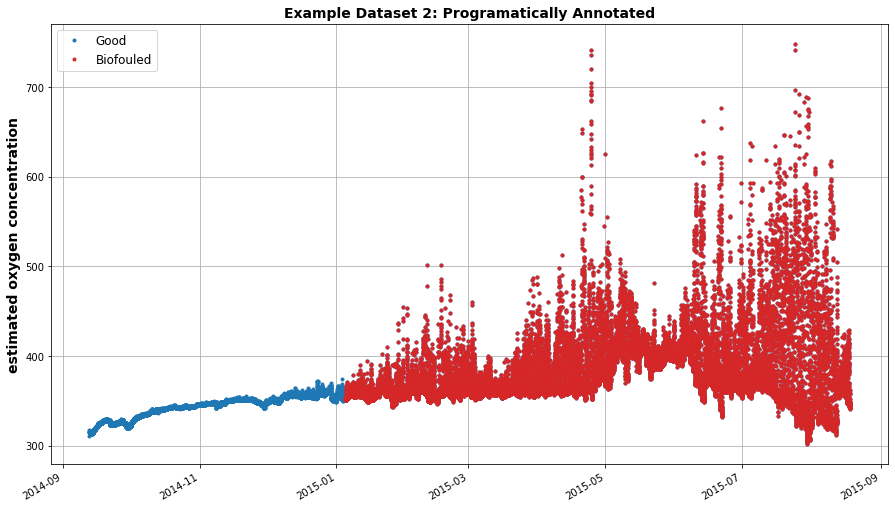

In [14]:
# Get our data exclusion start date and use that as a mask
exclusion_date = get_qcflag_start_date(data2_qcflag_5)
mask = data2["time"] >= exclusion_date


# Plot the dataset with the annotations
# Set the figure size and axes
fig, ax = plt.subplots(figsize=(15, 9))

# Plot the oxygen data
ax.plot(data2["time"], data2["estimated_oxygen_concentration"], marker=".", linestyle="", color="tab:blue", label="Good")

# Find and plot just the annotations using "pandas-like" boolean masking
ax.plot(data2["time"][mask], data2["estimated_oxygen_concentration"][mask], marker=".", linestyle="", color="tab:red", label="Biofouled")

# Add the lables, legends, grid, etc
ax.set_ylabel("estimated oxygen concentration", fontsize=14, weight="bold")
ax.grid()
ax.legend(fontsize=12)
ax.set_title("Example Dataset 2: Programatically Annotated", fontsize=14, weight="bold")

# Set the x-axis as a time axis
fig.autofmt_xdate()

## Analysis
#### What are the shortcomings?
Well, this is essentially a function that counts to seven, so it's not particularly sophisticated. While it performed well for the two sample datasets, there could be features of other datasets that it does not handle correctly.
#### Can it be improved?
For sure. This is just a starting point given the time constraints of the hack week. There may be more elegant or efficient ways of accomplishing the same thing, and it could be modified to look for different features within a dataset.
#### What about the metric for programatically identifying suspect data?
I was not able to devise an accurate, robust way to do this, with my limited knowledge of statistical analasis. But this function can be used with any metric that is able to flag data according to some threshold, as I did with daily standard deviation.

## Application

1. Use the metric devised by group member Rieke to determine the data exclusion date

In [30]:
# @author: rieke
#create new variable that is 0 (False) when above threshold, and 1 (True) when below
def assignStatus(datarray, name, threshold = 30, timerange = False):
    
    #remove change variable if already defined
    if "changeOxygen" in datarray.data_vars:    
        datarray = datarray.drop("changeOxygen")
    
    if timerange == False:
        datarray = datarray.assign(changeOxygen = abs(datarray.diff("time").estimated_oxygen_concentration))
    
    else:
        #calculte mean over the specified time range, take differene between consecutve times
        datarrayShort = abs(datarray.resample(time=timerange).mean().diff("time").estimated_oxygen_concentration)
        datarrayShort.name = "changeOxygen"
        #assign dfference back to original dataframe
        datarray = xr.combine_by_coords([datarray, datarrayShort.reindex_like(datarray, method = "ffill")], join = "right", coords = "time")
    
    #compare difference to given threshold
    #0 == False, 1 == True -> 0 means data is likely wrong, 1 means data is likely right
    datarray[name] = xr.where(datarray.changeOxygen > threshold, 0, 1)
    return datarray

#make regions with many bad data points completely bad
def expandStatus(datarray, name, nameExpanded, rollingtime, minRatio):
    datarray = datarray.assign(ratioGood = datarray[name].rolling(time = rollingtime, center = True).mean())
    #datarray.percentageGood.plot(x="time")
    datarray[nameExpanded] = xr.where(datarray.ratioGood < minRatio, 0, 1)
    
    return datarray

def flagStatus(datarray, name, nameExpanded, 
               threshold = 30, timerange = False, 
               rollingtime = 300, minRatio = 0.995):
    '''
    Assign 0 (bad) and 1 (good) to oxygen data based on the dfference between consecutive values

    Parameters
    ----------
    datarray : xArray Dataset
        dataset to be analysed.
    name : string
        name of the variable where the flag status of each time point is stored.
    nameExpanded : string
        name of the variable where the flag status of each time point is stored.
    threshold : integer, optional
        Threshold for the difference between consecutive values above which 0 is assigned. The default is 30.
    timerange : time, optional
        Optional time range (e.g. one day: 1D, one week: 1W, one month: 1M) over which a mean is taken. If not False, the difference between consecutive means is compared to the threshold. The default is False.
    rollingtime : integer, optional
        The time window over which the rolling mean is applied to expand the status. Over a window with this length, a mean is taken from the status (resulting in a ratio between 0 and 1). The default is 300.
    minRatio : float, optional
        Minimal ratio of good data points that needs to be reached over a window of length rollingtime to assign status good (1) to the data point. If the ratio is lower, bad (0) is assigned. The default is 0.995.

    Returns
    -------
    datarray : xArray Dataset
        Input data array with two additional variables, named name and nameExpanded. They give the data status based on the difference of consecutive values and the given parameters.

    '''
    
    datarray = assignStatus(datarray, name, threshold, timerange)
    
    datarray = expandStatus(datarray, name, nameExpanded, rollingtime, minRatio)
    
    return datarray

# Apply Rieke's function to dataset 1...
data1_rflag = flagStatus(data1, "good", "goodExpanded", timerange='1D', rollingtime=672)
data1_rflag

<xarray.Dataset>
Dimensions:                         (time: 33828)
Coordinates:
  * time                            (time) datetime64[ns] 2014-06-18T06:00:01...
Data variables:
    changeOxygen                    (time) float32 nan nan nan ... 4.388 4.388
    estimated_oxygen_concentration  (time) float32 343.4 344.6 ... 350.6 350.6
    deployment                      (time) float64 2.0 2.0 2.0 ... 2.0 2.0 2.0
    dissolved_oxygen                (time) float64 nan nan nan ... nan nan nan
    rollup_annotations_qc_results   (time) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    good                            (time) int64 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1
    ratioGood                       (time) float64 nan nan nan ... nan nan nan
    goodExpanded                    (time) int64 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1
Attributes: (12/69)
    node:                               RIS01
    comment:                            Data collected from the OOI M2M API a...
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  telemetered
    stream:                             dosta_abcdjm_sio_instrument
    ...                                 ...
    geospatial_lon_resolution:          0.1
    geospatial_vertical_units:          meters
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_positive:       down
    lat:                                49.9775
    lon:                                -144.2463

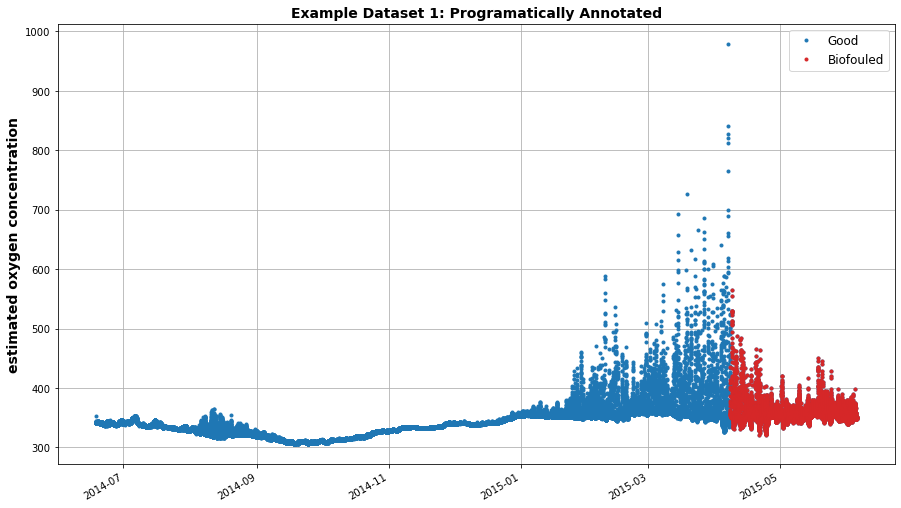

In [31]:
# Plot data using Rieke's metric...

# Get our data exclusion start date and use that as a mask
exclusion_date = get_qcflag_start_date(data1_rflag.good)
mask = data1["time"] >= exclusion_date


# Plot the dataset with the annotations
# Set the figure size and axes
fig, ax = plt.subplots(figsize=(15, 9))

# Plot the oxygen data
ax.plot(data1["time"], data1["estimated_oxygen_concentration"], marker=".", linestyle="", color="tab:blue", label="Good")

# Find and plot just the annotations using "pandas-like" boolean masking
ax.plot(data1["time"][mask], data1["estimated_oxygen_concentration"][mask], marker=".", linestyle="", color="tab:red", label="Biofouled")

# Add the lables, legends, grid, etc
ax.set_ylabel("estimated oxygen concentration", fontsize=14, weight="bold")
ax.grid()
ax.legend(fontsize=12)
ax.set_title("Example Dataset 1: Programatically Annotated", fontsize=14, weight="bold")

# Set the x-axis as a time axis
fig.autofmt_xdate()

2. Use the metric devised by group member Sunny to determine the data exclusion date

In [38]:
# Plot dataset using Sunny's metric
data1_s = xr.load_dataset('data/dataset1_rolling.nc')
data1_s

<xarray.Dataset>
Dimensions:                         (time: 33828)
Coordinates:
  * time                            (time) datetime64[ns] 2014-06-18T06:00:01...
Data variables: (12/13)
    estimated_oxygen_concentration  (time) float32 343.4 344.6 ... 350.6 350.6
    deployment                      (time) float64 2.0 2.0 2.0 ... 2.0 2.0 2.0
    dissolved_oxygen                (time) float64 nan nan nan ... nan nan nan
    rollup_annotations_qc_results   (time) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    standardized_o2_conc            (time) float64 -0.08069 -0.04117 ... 0.1578
    mean                            (time) float64 nan nan nan ... 0.3965 0.3964
    ...                              ...
    mad                             (time) float64 nan nan nan ... 0.2504 0.2504
    std                             (time) float64 nan nan nan ... 0.3208 0.3209
    skew                            (time) float64 nan nan nan ... 1.056 1.056
    mean-median                     (time) float64 nan nan nan ... 0.1373 0.1372
    skew_mask                       (time) bool False False False ... True True
    mean_median_mask                (time) bool False False False ... True True
Attributes: (12/69)
    node:                               RIS01
    comment:                            Data collected from the OOI M2M API a...
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  telemetered
    stream:                             dosta_abcdjm_sio_instrument
    ...                                 ...
    geospatial_lon_resolution:          0.1
    geospatial_vertical_units:          meters
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_positive:       down
    lat:                                49.9775
    lon:                                -144.2463

In [43]:
# Using skew mask...
exclusion_date = get_qcflag_start_date(data1_s.skew_mask, 672)

exclusion_date


<xarray.DataArray 'time' ()>
array('2014-10-24T05:15:01.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2014-10-24T05:15:01

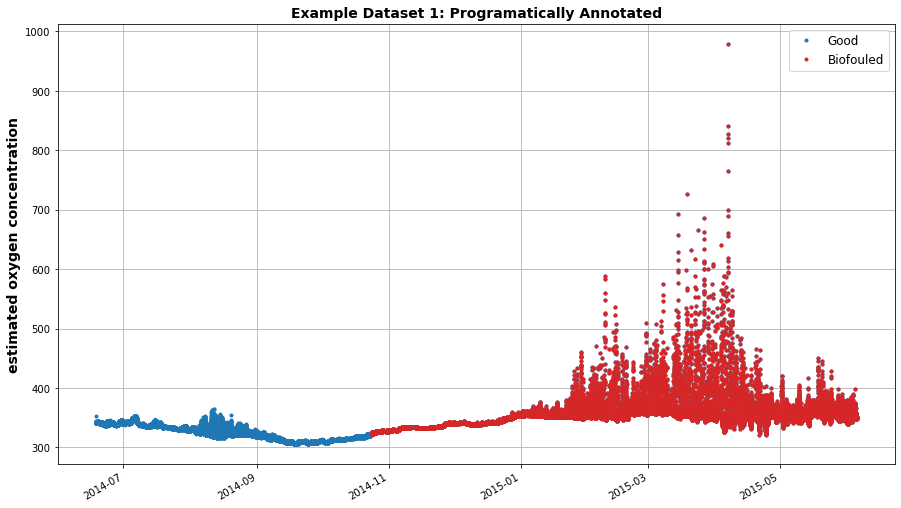

In [44]:
mask = data1["time"] >= exclusion_date


# Plot the dataset with the annotations
# Set the figure size and axes
fig, ax = plt.subplots(figsize=(15, 9))

# Plot the oxygen data
ax.plot(data1["time"], data1["estimated_oxygen_concentration"], marker=".", linestyle="", color="tab:blue", label="Good")

# Find and plot just the annotations using "pandas-like" boolean masking
ax.plot(data1["time"][mask], data1["estimated_oxygen_concentration"][mask], marker=".", linestyle="", color="tab:red", label="Biofouled")

# Add the lables, legends, grid, etc
ax.set_ylabel("estimated oxygen concentration", fontsize=14, weight="bold")
ax.grid()
ax.legend(fontsize=12)
ax.set_title("Example Dataset 1: Programatically Annotated", fontsize=14, weight="bold")

# Set the x-axis as a time axis
fig.autofmt_xdate()

In [53]:
# Using mean-median mask...
exclusion_date = get_qcflag_start_date(data1_s.mean_median_mask, 96)

exclusion_date


<xarray.DataArray 'time' ()>
array('2014-11-14T08:15:01.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2014-11-14T08:15:01

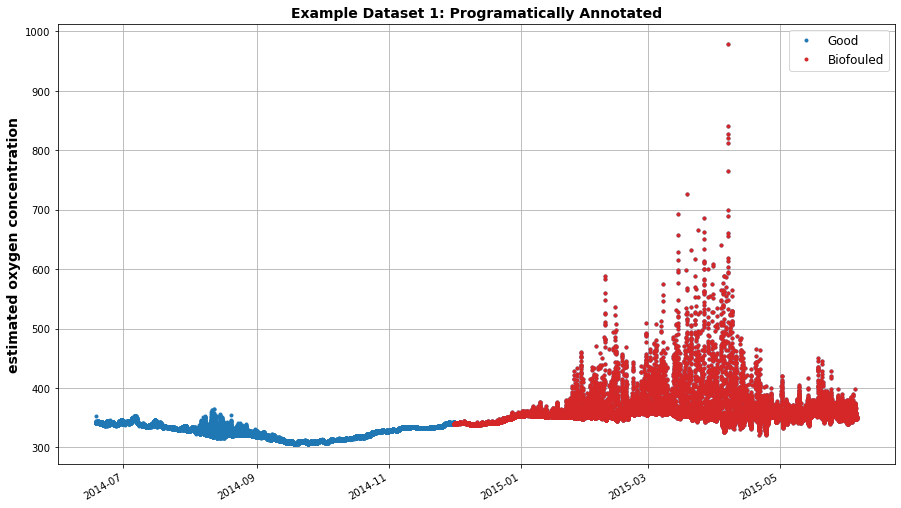

In [51]:
mask = data1["time"] >= exclusion_date


# Plot the dataset with the annotations
# Set the figure size and axes
fig, ax = plt.subplots(figsize=(15, 9))

# Plot the oxygen data
ax.plot(data1["time"], data1["estimated_oxygen_concentration"], marker=".", linestyle="", color="tab:blue", label="Good")

# Find and plot just the annotations using "pandas-like" boolean masking
ax.plot(data1["time"][mask], data1["estimated_oxygen_concentration"][mask], marker=".", linestyle="", color="tab:red", label="Biofouled")

# Add the lables, legends, grid, etc
ax.set_ylabel("estimated oxygen concentration", fontsize=14, weight="bold")
ax.grid()
ax.legend(fontsize=12)
ax.set_title("Example Dataset 1: Programatically Annotated", fontsize=14, weight="bold")

# Set the x-axis as a time axis
fig.autofmt_xdate()